# V-n Diagram

This section illustrates how to create a V-n diagram for the example airplane. This diagram relates equivalent airspeed to the structural loads experienced by the airframe, which are later used in structural analysis. Essentially, it defines the operating envelope for the airplane in terms of the maximum maneuvers and speeds. Refer to [FAR Part 23 Subpart C](https://www.ecfr.gov/current/title-14/chapter-I/subchapter-C/part-23/subpart-C) for regulations related to airplane structures. Refer to lecture notes, Raymer section 14.3.1 and 14.3.2, and Roskam Part 5 section 4.2 for more details.

In this demonstration, the V-n diagram is created at sea-level conditions and in clean configuration, and aircraft is at MTOW. Below table outlines various quantities used for creating the V-n diagram. The wing loading, wing reference area, and mean aerodynamic chord can be obtained by initializing the `AircraftParameters` class using the best aspect ratio, wing loading and power loading obtained from trade studies. The maximum positive and negative (clean) lift coefficient are obtained using the method described in [aerodynamics section](../aerodynamics/lift_curve.ipynb).

<div style="width:70%; margin: auto;">

Parameter | Value | Source
--------- | :---: | :---:
Wing loading, $W/S$ | 42.8 lbs/$\text{ft}^2$ | trade study
Wing area, S | 138 $\text{ft}^2$ | computed
Mean aerodynamic chord, $\bar{c}$ | 4.16 ft | computed
Max positive lift coefficient, $C_{L_{max^+}}$ | 1.5 | computed
Max negative lift coefficient, $C_{L_{max^-}}$ | -1.1 | computed
</div>

Below code block imports required packages and defines some variables:

In [1]:
import nbimporter
from mtow import compute_takeoff_weight
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np

# From trade study
A = 9
wing_loading = 45.3 # lbs/sq ft
power_loading = 8.7 # lbs/hp

# Size the aircraft
MTOW, aircraft = compute_takeoff_weight(wing_loading, power_loading, A)

# Variables
Pmax_sealevel = aircraft.P_takeoff # hp
Pmax_cruise = aircraft.P_cruise # hp
rho_cruise = aircraft.rho_cruise # slugs/cu ft
rho_sealevel = aircraft.rho_sea_level # slugs/cu ft
prop_eff = aircraft.prop_eff_cruise
e = aircraft.e
S = aircraft.S # sq ft
CD0 = aircraft.CD0
CLmax = 1.5
CLmax_neg = -1.1

## Load factor

The first step is to determine the limit load factor $n$ using

$$
    n_+ \geq 2.1 + \frac{24000}{W + 10000} \quad \text{and} \quad n_- \leq -0.4 n_+
$$

where $W$ is the weight, $n_+$ and $n_-$ are the positive and negative limit load factor, respectively. Note that this positive load factor is used for computing ultimate load factor while estimating [weights](../weight_and_balance/weight.ipynb) of different components.

Below code block computes these two load factors:

In [2]:
# Load factor
nplus = 2.1 + 24000 / (MTOW + 10000)
nminus = -0.4*nplus

print(f"Positive load factor: {nplus:.2f}")
print(f"Negative load factor: {nminus:.2f}")

Positive load factor: 3.58
Negative load factor: -1.43


## Speeds

Next step is to determine the important speeds used in V-n diagram:

1. 1g stall speed, $V_S$
2. Design cruise speed, $V_C$
3. Maximum level flight speed, $V_H$
4. Design dive speed, $V_D$

The $V_S$ and $V_C$ are known while $V_H$ can be computed based on the maximum available cruise power. The $V_D$ is a design choice which can be set by the designer. Ensure that the lower limit for $V_C$ and $V_D$ are satisfied. Note that all these speeds should be in equivalent airspeeds.

Below code block computes/defines these speeds. It also defines a function for computing equivalent airspeed for a given true airspeed and density.

In [3]:
# Compute equivalent air speed
compute_Ve = lambda x, rho: (rho/rho_sealevel)**0.5 * x # rho should be in slugs/cu ft

# Speed
VS = (wing_loading * 2 / rho_sealevel / CLmax )**0.5 / 1.688 # kts, equivalent airspeed
VS_neg = (wing_loading * 2 / rho_sealevel / np.abs(CLmax_neg) )**0.5 / 1.688 # kts, equivalent airspeed
VC = compute_Ve(200, rho_cruise) # kts, equivalent airspeed
VD = 240 # kts, equivalent airspeed

def compute_power(x, weight, S, CD0):
    """
        Function to compute drag for a given velocity
    """

    dyn_pressure = 0.5 * rho_cruise * x**2 # slugs/cu ft

    CL = weight / dyn_pressure / S

    CD = CD0 + CL**2/np.pi/A/e

    D = CD * dyn_pressure * S # lbs

    power = D * x / prop_eff / 550 # hp

    return power

# Equation which needs to be solved to find the velocity at max power
eqn = lambda x, weight, S, CD0: compute_power(x, weight, S, CD0) - Pmax_cruise

x0 = 350 # ft/s

VH = fsolve(eqn, x0=x0, args=(MTOW, S, CD0)).item() / 1.68781 # kts, true airspeed
VH = compute_Ve(VH, rho_cruise) # kts, equivalent airspeed

# some other speeds
Va_pos = VS * nplus**0.5 # kts, equivalent airspeed
Va_neg = VS_neg * np.abs(nminus)**0.5 # kts, equivalent airspeed

print(f"Positive stall speed: {VS:.0f} kts")
print(f"Negative stall speed: {VS_neg:.0f} kts")
print(f"\nCorner speed (positive): {Va_pos:.0f} kts")
print(f"Corner speed (negative): {Va_neg:.0f} kts")
print(f"\nDesign cruise speed: {VC:.0f} kts")
print(f"Max speed at cruising altitude: {VH:.0f} kts")
print(f"Design dive speed: {VD:.0f} kts")

Positive stall speed: 94 kts
Negative stall speed: 110 kts

Corner speed (positive): 179 kts
Corner speed (negative): 132 kts

Design cruise speed: 177 kts
Max speed at cruising altitude: 191 kts
Design dive speed: 240 kts


Note that the design cruise speed is less than corner speed (positive). This implies that the airplane will stall first before reaching the limit load at cruise speed. This may not be true always.

## Stall lines

Once stall speed and corner speed are computed, stall lines can be computed. These lines depict the maximum load factor that can be attained at a given speed before airplane stalls. These lines are given by

$$
    n_+(V) = \frac{1}{2}\rho V^2\frac{C_{L_{max}}}{W/S} \quad \text{and} \quad n_-(V) = \frac{1}{2}\rho V^2\frac{C_{L_{max^-}}}{W/S},
$$

where $\rho$ is the sea-level density and $V$ should be in ft/s. Below code block computes these lines for a range of airspeeds:

In [4]:
# function for computing the stall line
stall_line = lambda V, CLmax: 0.5 * rho_sealevel * V**2 * CLmax / wing_loading

# Positive stall line
V_stall_line_pos = np.linspace(VS, Va_pos, 100) # kts, equivalent airspeed
stall_line_pos = stall_line(V_stall_line_pos*1.688, CLmax)

# Negative stall line
V_stall_line_neg = np.linspace(VS_neg, Va_neg, 100) # kts, equivalent airspeed
stall_line_neg = stall_line(V_stall_line_neg*1.688, CLmax_neg)

## Initial plot

Below code block creates V-n diagram for the example airplane. Note that the following diagram does not account for gust speeds.

Text(0.5, 1.0, 'Without Gusts')

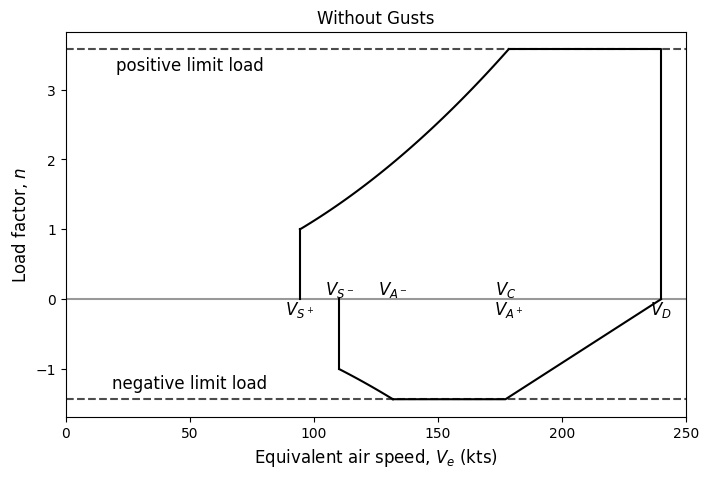

In [5]:
fs = 12

fig, ax = plt.subplots(figsize=(8,5))

ax.axhline(y=nplus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=nminus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=0, linestyle="-", color="k", alpha=0.4)

# Positive load factor
ax.plot([VS, VS], [0, 1], "k")
ax.plot(V_stall_line_pos, stall_line_pos, "k")
ax.plot([Va_pos, VD, VD], [nplus, nplus, 0], "k")

# Negative load factor
ax.plot([VS_neg, VS_neg], [0, -1], "k")
ax.plot(V_stall_line_neg, stall_line_neg, "k")
ax.plot([Va_neg, VC, VD], [nminus, nminus, 0], "k")

# Annotations
ax.annotate("$V_{S^+}$", (VS,0), fontsize=fs, ha="center", va="top")
ax.annotate("$V_{S^-}$", (VS_neg,0), fontsize=fs, ha="center", va="bottom")

ax.annotate("$V_{A^+}$", (Va_pos,0), fontsize=fs, ha="center", va="top")
ax.annotate("$V_{A^-}$", (Va_neg,0), fontsize=fs, ha="center", va="bottom")

ax.annotate("$V_C$", (VC,0), fontsize=fs, ha="center", va="bottom")
ax.annotate("$V_D$", (VD,0), fontsize=fs, ha="center", va="top")

ax.annotate("positive limit load", (50,nplus-0.1), ha="center", va="top", fontsize=fs)
ax.annotate("negative limit load", (50,nminus+0.1), ha="center", va="bottom", fontsize=fs)

# Asthetics
ax.set_xlim(left=0, right=250)
ax.set_xlabel("Equivalent air speed, $V_e$ (kts)", fontsize=fs)
ax.set_ylabel("Load factor, $n$", fontsize=fs)
ax.set_title("Without Gusts", fontsize=fs)

## Gusts

For FAR Part 23 airplanes flying below 20,000 ft, the airplane must be able to withstand two different gust loads: $\pm$ 50 ft/s at $V_C$ and $\pm$ 25 ft/s at $V_D$. A statistical approach based on gust alleviation factor is used to determine the gust lines in V-n diagram. Refer to lecture notes for more details. Below code block computes gust alleviation factor and gust lines:

In [6]:
# Variables
g = 32.2 # ft/s^2
CLalpha = 5.1 # 1/rad, computed
MGC = 3.92 # ft, computed

# Compute gust alleviation factor
mu_g = 2 * wing_loading / rho_sealevel / CLalpha / g / MGC
Kg = 0.88*mu_g / (5.3 + mu_g)

# Compute gust lines
compute_gust_line = lambda x, V_gust: 1 + Kg * V_gust * CLalpha / 498 / wing_loading * x # V_gust should be in ft/s nad x should be in KEAS

# Vc gust lines
V_gust_line_VC = np.linspace(0,VC,200) # KEAS
VC_gust_line_pos = compute_gust_line(V_gust_line_VC, 50)
VC_gust_line_neg = compute_gust_line(V_gust_line_VC, -50)

# VD gust lines
V_gust_line_VD = np.linspace(0,VD,200) # KEAS
VD_gust_line_pos = compute_gust_line(V_gust_line_VD, 25)
VD_gust_line_neg = compute_gust_line(V_gust_line_VD, -25)

Below code block plots the V-n diagram with gust lines only:

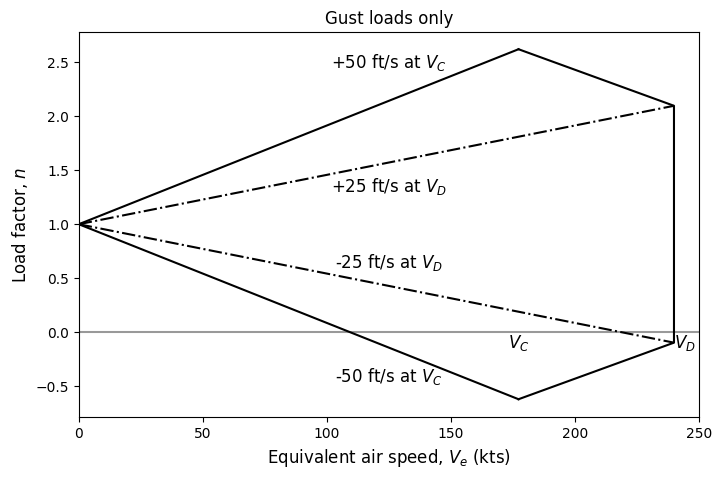

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

ax.axhline(y=0, linestyle="-", color="k", alpha=0.4)

# +-50 ft/s gust lines - VC
ax.plot(V_gust_line_VC, VC_gust_line_pos, "k-")
ax.plot(V_gust_line_VC, VC_gust_line_neg, "k-")

# +-25 ft/s gust lines - VD
ax.plot(V_gust_line_VD, VD_gust_line_pos, "k-.")
ax.plot(V_gust_line_VD, VD_gust_line_neg, "k-.")

# Close the diagram
ax.plot([V_gust_line_VC[-1], V_gust_line_VD[-1], V_gust_line_VD[-1], V_gust_line_VC[-1]],
        [VC_gust_line_pos[-1], VD_gust_line_pos[-1], VD_gust_line_neg[-1], VC_gust_line_neg[-1]], "k-")

# Annotations
ax.annotate("$V_C$", (VC,0), fontsize=fs, ha="center", va="top")
ax.annotate("$V_D$", (VD,0), fontsize=fs, ha="left", va="top")

ax.annotate("+25 ft/s at $V_D$", (125,1.45), ha="center", va="top", fontsize=fs)
ax.annotate("-25 ft/s at $V_D$", (125,0.55), ha="center", va="bottom", fontsize=fs)

ax.annotate("+50 ft/s at $V_C$", (125,2.4), ha="center", va="bottom", fontsize=fs)
ax.annotate("-50 ft/s at $V_C$", (125,-0.5), ha="center", va="bottom", fontsize=fs)

# Asthetics
ax.set_xlim(left=0, right=250)
ax.set_xlabel("Equivalent air speed, $V_e$ (kts)", fontsize=fs)
ax.set_ylabel("Load factor, $n$", fontsize=fs)
_ = ax.set_title("Gust loads only", fontsize=fs)

## Final plot

Next step is to combine both the maneuver and gust envelopes. One should select the highest load factor between the maneuver and gust envelopes at $V_C$ and $V_D$. Note that the ultimate load factor should be the greatest load factor in V-n. Below code block plots the final V-n diagram

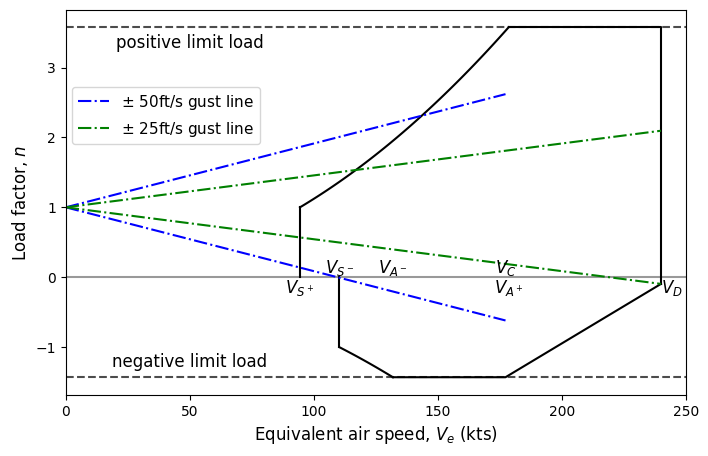

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

ax.axhline(y=nplus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=nminus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=0, linestyle="-", color="k", alpha=0.4)

# Positive load factor
ax.plot([VS, VS], [0, 1], "k")
ax.plot(V_stall_line_pos, stall_line_pos, "k")
ax.plot([Va_pos, VD, VD], [nplus, nplus, VD_gust_line_neg[-1]], "k")

# Negative load factor
ax.plot([VS_neg, VS_neg], [0, -1], "k")
ax.plot(V_stall_line_neg, stall_line_neg, "k")
ax.plot([Va_neg, VC, VD], [nminus, nminus, VD_gust_line_neg[-1]], "k")

# +-50 ft/s gust lines - VC
ax.plot(V_gust_line_VC, VC_gust_line_pos, "b-.", label="$\pm$ 50ft/s gust line")
ax.plot(V_gust_line_VC, VC_gust_line_neg, "b-.")

# +-25 ft/s gust lines - VD
ax.plot(V_gust_line_VD, VD_gust_line_pos, "g-.", label="$\pm$ 25ft/s gust line")
ax.plot(V_gust_line_VD, VD_gust_line_neg, "g-.")

# Annotations
ax.annotate("$V_{S^+}$", (VS,0), fontsize=fs, ha="center", va="top")
ax.annotate("$V_{S^-}$", (VS_neg,0), fontsize=fs, ha="center", va="bottom")

ax.annotate("$V_{A^+}$", (Va_pos,0), fontsize=fs, ha="center", va="top")
ax.annotate("$V_{A^-}$", (Va_neg,0), fontsize=fs, ha="center", va="bottom")

ax.annotate("$V_C$", (VC,0), fontsize=fs, ha="center", va="bottom")
ax.annotate("$V_D$", (VD,0), fontsize=fs, ha="left", va="top")

ax.annotate("positive limit load", (50,nplus-0.1), ha="center", va="top", fontsize=fs)
ax.annotate("negative limit load", (50,nminus+0.1), ha="center", va="bottom", fontsize=fs)

# Asthetics
ax.legend(fontsize=fs-1, loc=(0.01,0.65))
ax.set_xlim(left=0, right=250)
ax.set_xlabel("Equivalent air speed, $V_e$ (kts)", fontsize=fs)
ax.set_ylabel("Load factor, $n$", fontsize=fs)

plt.show()

In this case, the -25 ft/s gust load factor at $V_D$ exceeds the maneuver load factor. Apart from this, the gust load factors at other $V_C$ and $V_D$ points are within the maneuver envelope. Hence, the maneuver envelope will be the final V-n diagram with a small modification at $V_D$. Note that this V-n diagram is only for the example airplane, it will not be same for other airplanes.

This concludes the V-n diagram section.